In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, gc
import sys
import yaml
import argparse
from collections import defaultdict
from tqdm import tqdm
from IPython.core.display import display, HTML
from glob import glob

import pandas as pd
import numpy as np

import cv2
from PIL import Image
import pytesseract
from pytesseract import Output

from scipy import ndimage as ndi
from scipy import signal

from skimage.color import rgb2gray
from skimage.filters import gabor, threshold_otsu, threshold_multiotsu, try_all_threshold, threshold_triangle
from skimage import exposure, filters, morphology, graph, measure, color
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import clear_border
from skimage.morphology import opening, closing, square, skeletonize, medial_axis, erosion, dilation, thin
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate, resize

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.nn.functional as F

sys.path.insert(0, 'D:\Ground\BolorSoft-OCR\deep-text-recognition-benchmark')
from model import Model
from utils import CTCLabelConverter, AttnLabelConverter, Averager
from dataset import RawDataset, AlignCollate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
def read_opt(file_path):
    with open(file_path, 'r', encoding = 'utf-8') as f:
        config_dict = yaml.safe_load(f)

    opt = argparse.Namespace()
    for key, value in config_dict.items():
        setattr(opt, key, value)
    
    return opt

In [3]:
def get_model(opt_path = 'mn_conf\inference_parameters_conf.yaml'):
    opt = read_opt(opt_path)
    if 'CTC' in opt.Prediction:
        converter = CTCLabelConverter(opt.character)
    else:
        converter = AttnLabelConverter(opt.character)
    opt.num_class = len(converter.character)

    if opt.rgb:
        opt.input_channel = 3

    model = Model(opt)
    print('model input parameters', opt.imgH, opt.imgW, opt.num_fiducial, opt.input_channel, opt.output_channel,
        opt.hidden_size, opt.num_class, opt.batch_max_length, opt.Transformation, opt.FeatureExtraction,
        opt.SequenceModeling, opt.Prediction)

    #model = torch.nn.DataParallel(model).to(device)
    state_dict = torch.load(opt.saved_model, map_location = device)
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)

    return model.to(device), converter, opt

In [4]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
data_dir = 'mn_recognition_data/simple_ocr_data'
print(len(os.listdir(data_dir)))

12


# 1. Удиртгал

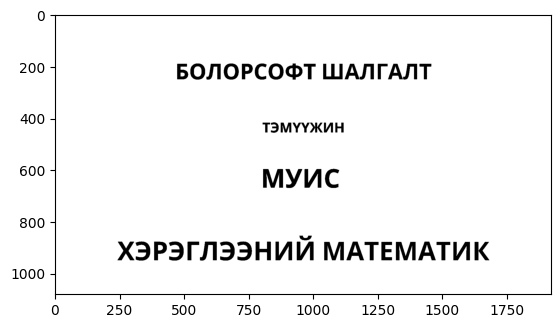

In [5]:
img = np.asarray(Image.open('mn_recognition_data/simple_ocr_data/img_1.png').convert('L'))
thresh = threshold_multiotsu(img)[1]
img_masked = np.uint8(img > thresh)*255
plt.imshow(img_masked, cmap = 'gray');

3549

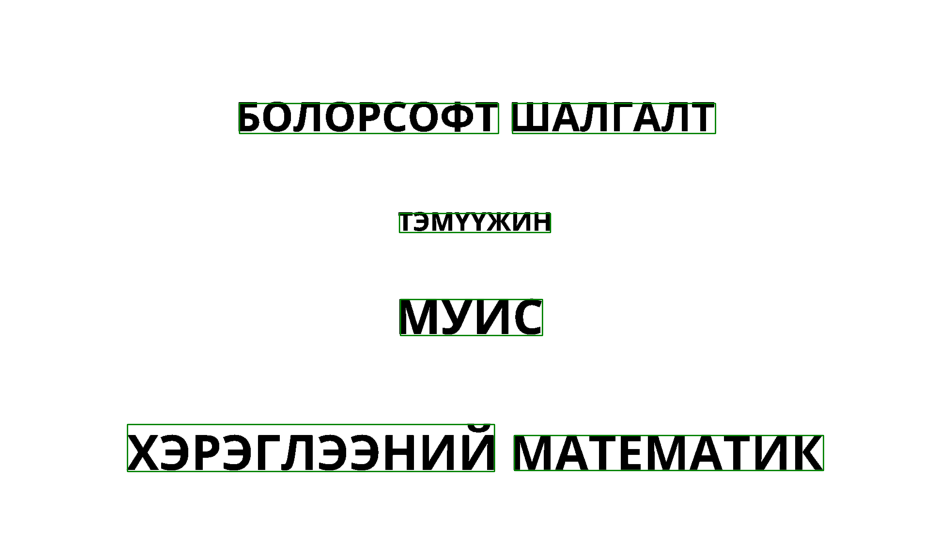

In [6]:
data = pytesseract.image_to_data(img_masked, output_type=Output.DICT)
n_boxes = len(data["text"])

largest_boxes = defaultdict(lambda: {'x': 0, 'y': 0, 'w': 0, 'h': 0, 'area': 0})

for i in range(n_boxes):
    if data["conf"][i] == -1 or not data["text"][i].strip():
        continue

    x, y = data["left"][i], data["top"][i]
    w, h = data["width"][i], data["height"][i]
    area = w * h

    word = data["text"][i].strip()
    position_key = (word, x // 10, y // 10)

    if area > largest_boxes[position_key]['area']:
        largest_boxes[position_key] = {'x': x, 'y': y, 'w': w, 'h': h, 'area': area}
        
fig, ax = plt.subplots(num = 1, clear = True, figsize = (12, 12))

ax.imshow(img_masked, cmap = 'gray')
ax.axis("off")

for box in largest_boxes.values():
    x, y, w, h = box['x'], box['y'], box['w'], box['h']
    rect = plt.Rectangle((x, y), w, h, edgecolor = 'green', facecolor = 'none', linewidth = 1)
    ax.add_patch(rect)

del fig, ax
gc.collect()

145

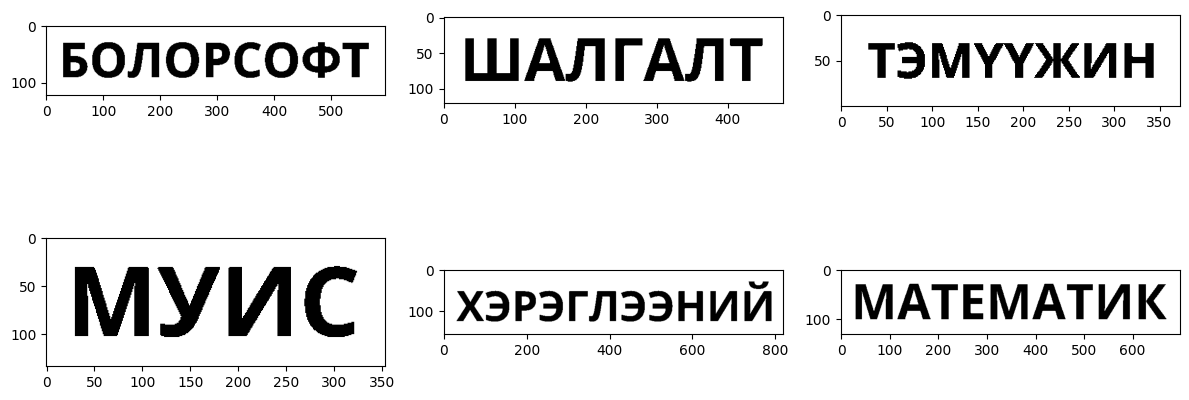

In [7]:
pad_size = 30
pad_value = (255, 255)
pad_width = ((pad_size, pad_size), (pad_size, pad_size))

fig, axes = plt.subplots(2, 3, figsize = (12, 6))
axes = axes.flatten()

for ax, (key, box) in zip(axes, largest_boxes.items()):
    x, y, w, h = box['x'], box['y'], box['w'], box['h']
    word_img = img_masked[y:y+h, x:x+w]
    word_img = np.pad(word_img, pad_width = pad_width, mode = 'constant', constant_values = pad_value)
    ax.imshow(cv2.cvtColor(word_img, cv2.COLOR_BGR2RGB))

fig.tight_layout()

del fig, ax, axes
gc.collect()

# 2. Зургаас эхлээд тэмдэгт ялгах

In [8]:
def pytess_bbox(img_masked, img_name, output_dir, savefig = False, dpi = 120):
    data = pytesseract.image_to_data(img_masked, output_type=Output.DICT)
    n_boxes = len(data["text"])

    largest_boxes = defaultdict(lambda: {'x': 0, 'y': 0, 'w': 0, 'h': 0, 'area': 0})

    for i in range(n_boxes):
        if data["conf"][i] == -1 or not data["text"][i].strip():
            continue

        x, y = data["left"][i], data["top"][i]
        w, h = data["width"][i], data["height"][i]
        area = w * h

        word = data["text"][i].strip()
        position_key = (word, x // 10, y // 10)

        if area > largest_boxes[position_key]['area']:
            largest_boxes[position_key] = {'x': x, 'y': y, 'w': w, 'h': h, 'area': area}

    if savefig:
        fig, ax = plt.subplots(num = 1, clear = True)

        ax.imshow(img_masked, cmap = 'gray')
        ax.axis("off")

        for box in largest_boxes.values():
            x, y, w, h = box['x'], box['y'], box['w'], box['h']
            rect = plt.Rectangle((x, y), w, h, edgecolor = 'green', facecolor = 'none', linewidth = 1)
            ax.add_patch(rect)
        
        fig.savefig(f"{output_dir}/{img_name}.png", dpi = dpi)

        del fig, ax
        gc.collect()

    return largest_boxes

In [9]:
pad_size = 30
pad_value = (255, 255)
pad_width = ((pad_size, pad_size), (pad_size, pad_size))

output_dir = f'{data_dir}/py_tess_bbox'
os.makedirs(output_dir, exist_ok = True)

bbox_dir = f"{output_dir}/single_word"
os.makedirs(bbox_dir, exist_ok = True)

bbox_pred_dir = f"{output_dir}/single_word_pred"
os.makedirs(bbox_pred_dir, exist_ok = True)

extensions = ["*.jpg", "*.jpeg", "*.png"]
images = []
for extension in extensions:
    images.extend(glob(os.path.join(data_dir, extension)))

Tesseract ашиглан оролтын зураг бүрээс тэмдэгтүүдийг ялгаж, ялгасан тэмдэгт бүрийг нэг зураг болгож хадгалах

In [10]:
import matplotlib
matplotlib.use('Agg')

for img_filename in tqdm(images, total = len(images), desc = 'Finding words'):
    img = np.asarray(Image.open(img_filename).convert('L'))
    thresh = threshold_multiotsu(img)[1]
    img_masked = np.uint8((img > thresh)*255)

    img_name = os.path.basename(img_filename).split('.')[0]
    largest_boxes = pytess_bbox(img_masked, img_name, output_dir, savefig = True, dpi = 120)

    for idx, (_, box) in enumerate(largest_boxes.items()):
        x, y, w, h = box['x'], box['y'], box['w'], box['h']
        word_img = img_masked[y: y + h, x: x + w]
        word_img = np.pad(word_img, pad_width = pad_width, mode = 'constant', constant_values = pad_value)

        word_img = Image.fromarray(word_img)
        word_img.save(f"{bbox_dir}/{img_name}_split_{idx}.png")

Finding words: 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]


Дээрх үр дүнг болон dataloader ашиглан тэмдэгт таних

In [11]:
def model_pred(model, converter, opt, output_dir, input_img_dir = "mn_recognition_data/simple_ocr_data", dpi = 120):
    AlignCollate_demo = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD)
    demo_data = RawDataset(root = input_img_dir, opt=opt)
    demo_loader = torch.utils.data.DataLoader(
        demo_data, batch_size=opt.batch_size,
        shuffle=False,
        num_workers=int(opt.workers),
        collate_fn=AlignCollate_demo, pin_memory=True)

    model.eval()
    with torch.no_grad():
        for image_tensors, image_path_list in tqdm(demo_loader):
            batch_size = image_tensors.size(0)
            image = image_tensors.to(device)
            text_for_pred = torch.LongTensor(batch_size, opt.batch_max_length + 1).fill_(0).to(device)

            preds = model(image, text_for_pred)
            # Greedy decoding
            preds_size = torch.IntTensor([preds.size(1)] * batch_size)
            _, preds_index = preds.max(2)
            preds_str = converter.decode(preds_index, preds_size)

            preds_prob = F.softmax(preds, dim=2)
            preds_max_prob, _ = preds_prob.max(dim=2)
            image_np = image.cpu().numpy()
            
            for i in range(batch_size):
                img_name = os.path.basename(image_path_list[i]).split('.')[0]
                pred = preds_str[i]
                pred_max_prob = preds_max_prob[i]
                confidence_score = pred_max_prob.cumprod(dim=0)[-1]

                # Plotting and stuff
                img_np = image_np[i].transpose(1, 2, 0)
                fig, ax = plt.subplots(num = 1, clear = True)
                ax.imshow(img_np[:, :, 0], cmap='gray')
                ax.set_title(f'Танисан тэмдэгт: {pred}, Итгэх хувь: {confidence_score.item()*100:0.4f}%')

                fig.tight_layout()
                fig.savefig(f'{output_dir}/{img_name}_pred.png', dpi = dpi)

                del fig, ax
                gc.collect()

In [12]:
model, converter, opt = get_model()
input_img_dir = bbox_dir

No Transformation module specified
model input parameters 32 100 20 1 256 256 208 80 None VGG BiLSTM CTC


In [13]:
model_pred(model, converter, opt, bbox_pred_dir, input_img_dir, dpi = 120)

100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


# Үр дүн

In [14]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

Нэмэлт үр дүн [энэ фолдерт](mn_recognition_data\simple_ocr_data\py_tess_bbox) байгаа.

## Showcase 1

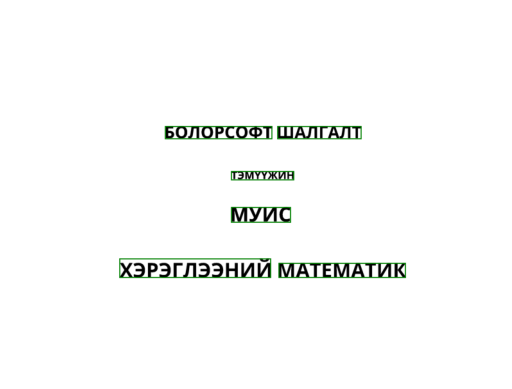

In [15]:
bbox_img = np.asarray(Image.open(f'{output_dir}/img_1.png'))
bbox_img_preds = [img_name for img_name in os.listdir(bbox_pred_dir) if 'img_1' in img_name]

plt.imshow(bbox_img, cmap = 'gray')
plt.axis('off');

3048

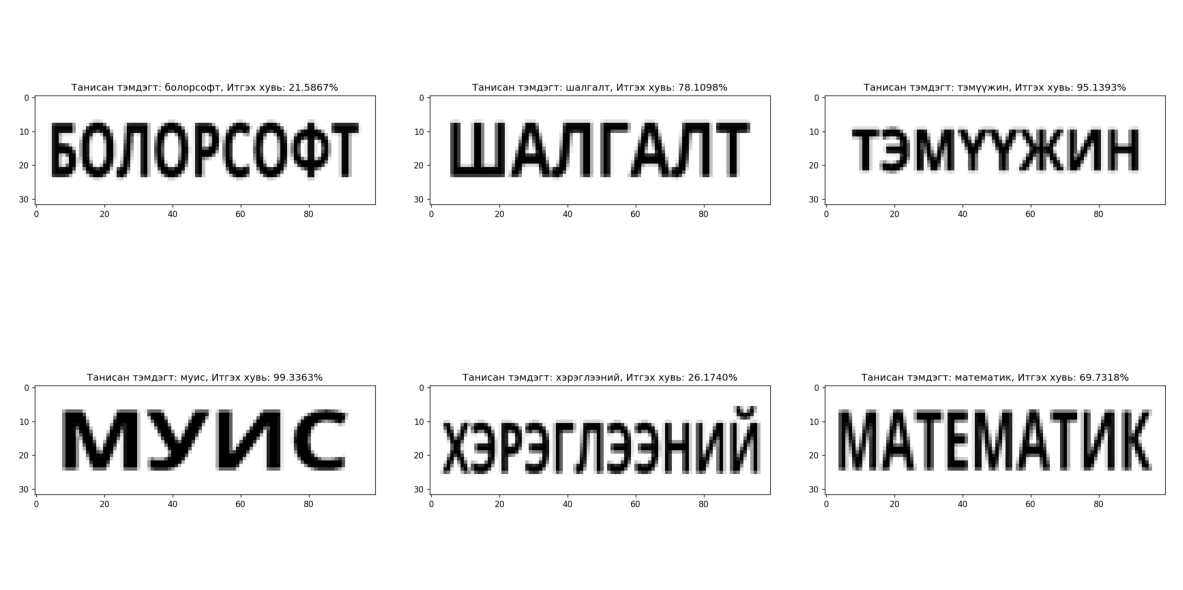

In [16]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))
axes = axes.flatten()

for idx, (ax, (key, box)) in enumerate(zip(axes, largest_boxes.items())):
    x, y, w, h = box['x'], box['y'], box['w'], box['h']
    word_img_pred = np.asarray(Image.open(f'{bbox_pred_dir}/{bbox_img_preds[idx]}'))
    ax.imshow(word_img_pred)
    ax.axis('off')

fig.tight_layout()

del fig, ax, axes
gc.collect()

## Showcase 2 etc

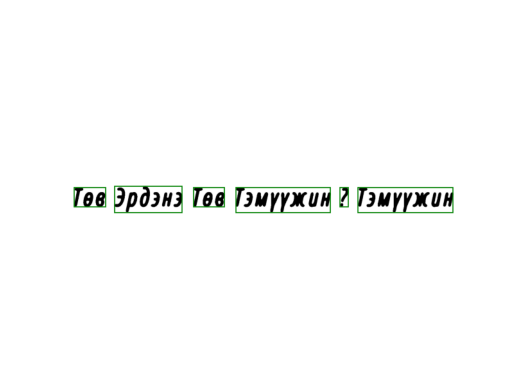

In [17]:
bbox_img = np.asarray(Image.open(f'{output_dir}/Төв Эрдэнэ Төв Тэмүүжин  Тэмүүжин_3.png'))
bbox_img_preds = [img_name for img_name in os.listdir(bbox_pred_dir) if 'Төв Эрдэнэ Төв Тэмүүжин  Тэмүүжин_3' in img_name]

plt.imshow(bbox_img, cmap = 'gray')
plt.axis('off');

11917

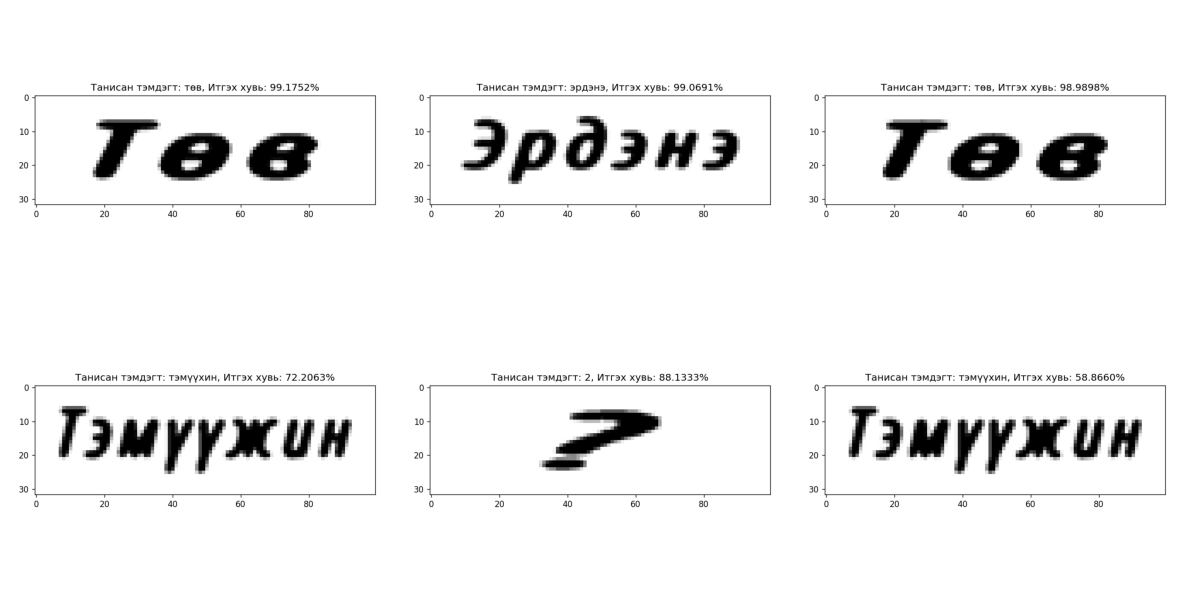

In [18]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))
axes = axes.flatten()

for idx, (ax, (key, box)) in enumerate(zip(axes, largest_boxes.items())):
    x, y, w, h = box['x'], box['y'], box['w'], box['h']
    word_img_pred = np.asarray(Image.open(f'{bbox_pred_dir}/{bbox_img_preds[idx]}'))
    ax.imshow(word_img_pred)
    ax.axis('off')

fig.tight_layout()

del fig, ax, axes
gc.collect()